# Learning covariance dictionaries on simulated data

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [8]:
import covdict
import sys
import time
from numpy import (arange, argmax, argsort, corrcoef, cov, diag, diag_indices, dot, empty, floor, 
                   hsplit, hstack, max, roll, triu_indices, vstack, zeros)
from numpy.linalg import norm
from numpy.random import multivariate_normal, rand, randn
from scipy.linalg import eigh

## Simulate covariance matrices evolving over time

#### Generate random covariance dictionary and weights

In [5]:
n = 100 # number of neurons
k = 4 # number of dictionary elements

# Random covariance dictionary
D = vstack([cov(randn(n, n))[triu_indices(n)] for i in range(k)]).T

# Structured weights
chk_len = 50
shift = 0.75 
n_cov = int(chk_len + (k - 1) * shift * chk_len) # number of input covariances
x = arange(chk_len) / float(chk_len)
template = 20 * hstack((-(x - 0.5) ** 2 + 0.3, zeros((k - 1) * chk_len)))
W = vstack([roll(template, int(i * shift * chk_len)) for i in range(k)])
W = W[:, : n_cov]

# Simulate input.
X = dot(D, W)

#### Plot weights of dictionary elements over time

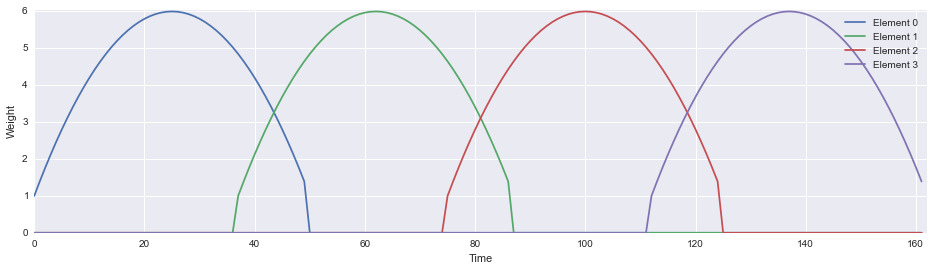

In [6]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));
plt.plot(W.T);

plt.xlim(0, n_cov);
plt.ylim(0, max(W) + 0.05);
plt.xlabel('Time');
plt.ylabel('Weight');
plt.legend(['Element ' + str(i) for i in range(k)]);

## Learn covariance dictionary using ALS vs. ADMM

#### Run ALS

In [ ]:
als = covdict.CovarianceDictionary(k=k, method='als', verbose=True, time=True, nls_beta=0.1, psdls_beta=0.1)
t = time.time()
Wals = als.fit_transform(X)
print str(time.time() - t) + ' seconds'

#### Plot objective per iteration and final weights

Initial gradient norm: 5244.189307.
Iter: 0. Projected gradient norm: 5244.189307. Objective: 0.985326.
Iter: 1. Projected gradient norm: 0.057206. Objective: 0.059031.
Iter: 2. Projected gradient norm: 0.071248. Objective: 0.005532.
Iter: 3. Projected gradient norm: 0.067872. Objective: 0.000698.
Iter: 4. Projected gradient norm: 0.067820. Objective: 0.000112.
Iter: 5. Projected gradient norm: 0.063234. Objective: 0.000033.
Iter: 6. Projected gradient norm: 0.059707. Objective: 0.000022.
Iter: 7. Final projected gradient norm 0.042628. Final objective 0.000021.
4.09903502464 seconds


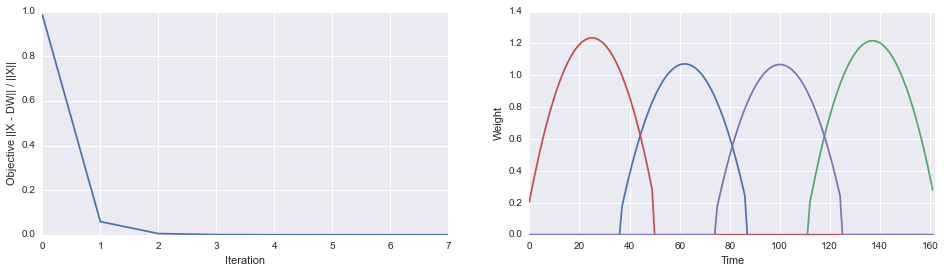

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(als.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wals.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

#### Compare ALS-learned and true dictionary elements

In [10]:
# Match ALS-learned and corresponding dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wals, axis=1))

# Correlate to account for scale factor
for a, b in zip(als.dictionary[:, match_idx].T, D.T):
    print corrcoef(a, b)[0, 1]

0.999999992987
0.999999999863
0.999999999923
0.999999911881


#### Run ADMM

In [ ]:
# Convergence quite sensitive to alpha and gamma (penalty and step size parameters) 
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, admm_alpha=0.1, admm_gamma=1)
t = time.time()
Wadmm = admm.fit_transform(X)
print str(time.time() - t) + ' seconds'

#### Plot objective per iteration and final weights

Iter: 0. Objective: 0.985326.
Iter: 100. Objective: 0.007640.
Iter: 200. Objective: 0.000740.
Iter: 209. Objective: 0.000642.
5.22646617889 seconds


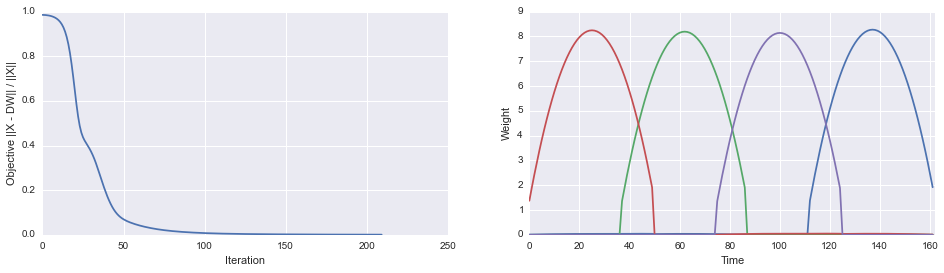

In [11]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmm.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

#### Compare ADMM-learned and true dictionary elements

In [12]:
# Match ADMM-learned and corresponding true dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wadmm, axis=1))

# Correlate to account for scale factor
for a, b in zip(admm.dictionary[:, match_idx].T, D.T):
    print corrcoef(a, b)[0, 1]

0.999992575631
0.999993295235
0.999989516949
0.999988259565


#### Compare objective over time for ALS vs. ADMM

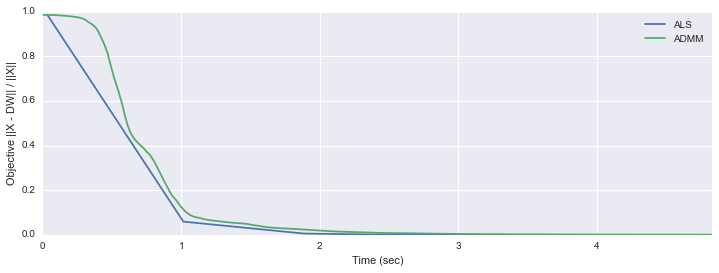

In [13]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4));
plt.plot(als.times, als.objective);
plt.plot(admm.times, admm.objective);
plt.xlim(0, max((admm.times[-1], als.times[-1])));
plt.xlabel('Time (sec)');
plt.ylabel('Objective ||X - DW|| / ||X||');
plt.legend(['ALS', 'ADMM']);

## Simulate multivariate Gaussian data

#### Draw samples from multivariate Gaussian and compute sample covariances

In [16]:
# Number of samples drawn per covariance matrix
n_samp = 2 * n

# Ignore non-PSD warnings due to numerical error (negative eigenvalues on order of 1e-17)
data = hstack([multivariate_normal(zeros(n), covdict.reform(X[:, i], n), n_samp).T for i in range(n_cov)])

# Compute sample covariance matrices
Xsample = vstack([cov(chunk)[triu_indices(n)] for chunk in hsplit(data, n_cov)]).T

/Users/fannjiangc/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: covariance is not positive-semidefinite.


#### Learn dictionary using ALS

In [19]:
als = covdict.CovarianceDictionary(k=k, method='als', verbose=True, time=True, nls_beta=0.8, psdls_beta=0.8)
t = time.time()
Wals = als.fit_transform(Xsample)
print str(time.time() - t) + ' seconds'

Initial gradient norm: 5247.696039.
Iter: 0. Projected gradient norm: 5247.696039. Objective: 0.988515.
Iter: 1. Projected gradient norm: 0.060720. Objective: 0.388386.
Iter: 2. Final projected gradient norm 0.046052. Final objective 0.384165.
5.89399313927 seconds


#### Plot objective per iteration and final weights

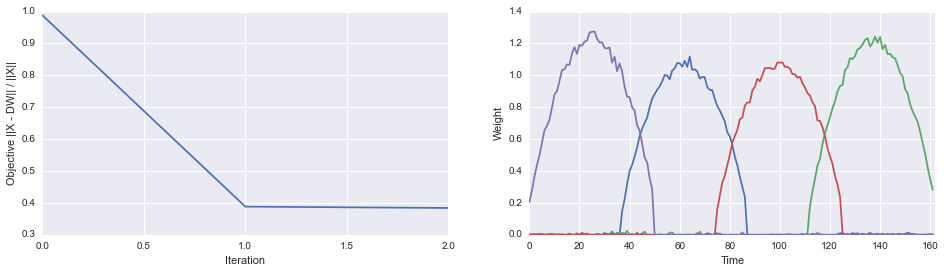

In [20]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(als.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wals.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

#### Compare ALS-learned and true dictionary elements

In [21]:
# Match ALS-learned and true dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wals, axis=1))

# Correlate to account for scale factor
print "Correlations between ALS-learned and true dictionary elements:"
for a, b in zip(als.dictionary[:, match_idx].T, D.T):
    print corrcoef(a, b)[0, 1]

Correlations between ALS-learned and true dictionary elements:
0.997354045329
0.997073301786
0.997001992724
0.997497584277


#### Learn dictionary using ADMM

In [22]:
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, admm_alpha=0.1, admm_gamma=2)
t = time.time()
Wadmm = admm.fit_transform(Xsample)
print str(time.time() - t) + ' seconds'

Iter: 0. Objective: 0.988515.
Iter: 95. Objective: 0.384162.
2.65360116959 seconds


#### Plot objective per iteration and final weights

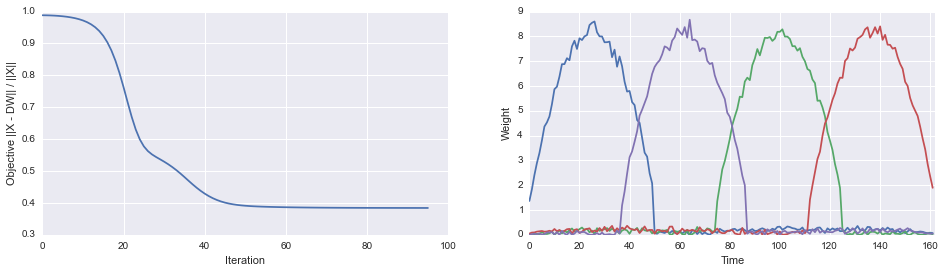

In [24]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmm.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

#### Compare ADMM-learned and true dictionary elements

In [27]:
# Match ADMM-learned to corresponding dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wadmm, axis=1))

# Correlate to account for scale factor.
print "Correlations between ADMM-learned and true dictionary elements:"
for a, b in zip(admm.dictionary[:, match_idx].T, D.T):
    print corrcoef(a, b)[0, 1]

Correlations between ADMM-learned and true dictionary elements:
0.99660069302
0.996352248992
0.996260277123
0.996721992546


#### Compare objective over time for ALS vs. ADMM

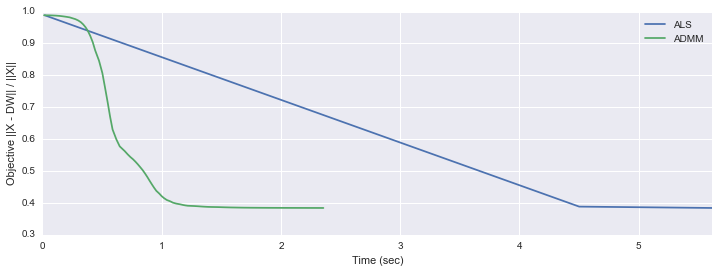

In [28]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4));
plt.plot(als.times, als.objective);
plt.plot(admm.times, admm.objective);
plt.xlim(0, max((admm.times[-1], als.times[-1])));
plt.xlabel('Time (sec)');
plt.ylabel('Objective ||X - DW|| / ||X||');
plt.legend(['ALS', 'ADMM']);